# Zadanie zaliczeniowe
Michał Januszkiewicz\
nr albumu: 459089

## Zadanie 1
Utworzyć ramkę danych, która dla każdego leku zawiera następujące informacje:
- unikalny identyfikator leku w bazie DrugBank,
- nazwę leku,
- jego typ,
- opis,
- postać w jakiej dany lek
występuje,
- wskazania,
- mechanizm działania,
- informacje z jakimi pokarmami dany lek
wchodzi w interakcje

In [2]:
import pandas as pd
from bs4 import BeautifulSoup

# returns BeautifulSoup object containing database from xml file
def import_xml(file_path):
    with open(file_path) as f:
    drugbank_file = f.read()
    return BeautifulSoup(drugbank_file, 'lxml-xml')

data = import_xml('drugbank.xml')

In [10]:
# returns DataFrame containing drugs data
def create_drugs_dataframe(data):
    drugs = []
    for drug in data.find('drugbank').find_all('drug', recursive=False): # recursive=False is needed because database contains nested drugs
        drug_id = drug.find('drugbank-id', {'primary': 'true'}, recursive=False).text
        drug_name = drug.find('name', recursive=False).text
        drug_type = drug.get('type')
        drug_description = drug.find('description', recursive=False).text
        drug_state = drug.find('state', recursive=False).text
        drug_indications = drug.find('indication', recursive=False).text
        drug_mechanism_of_action = drug.find('mechanism-of-action', recursive=False).text
        drug_food_interactions = [interaction.text for interaction in drug.find('food-interactions', recursive=False).find_all('food-interaction', recursive=False)]

        drugs.append({
            'DrugBank ID': drug_id,
            'Name': drug_name,
            'Type': drug_type,
            'Description': drug_description,
            'State': drug_state,
            'Indications': drug_indications,
            'Mechanism of Action': drug_mechanism_of_action,
            'Food Interactions': drug_food_interactions
        })

    return pd.DataFrame(drugs)

drugs_df = create_drugs_dataframe(data)


## Zadanie 2
Utworzyć ramkę danych pozwalającą na wyszukiwanie po DrugBank ID informacji o
wszystkich synonimach pod jakimi dany lek występuje.
Napisać funkcję, która dla podanego
DrugBank ID utworzy i wyrysuje graf synonimów za pomocą biblioteki NetworkX. Należy
zadbać o czytelność generowanego rysunku.

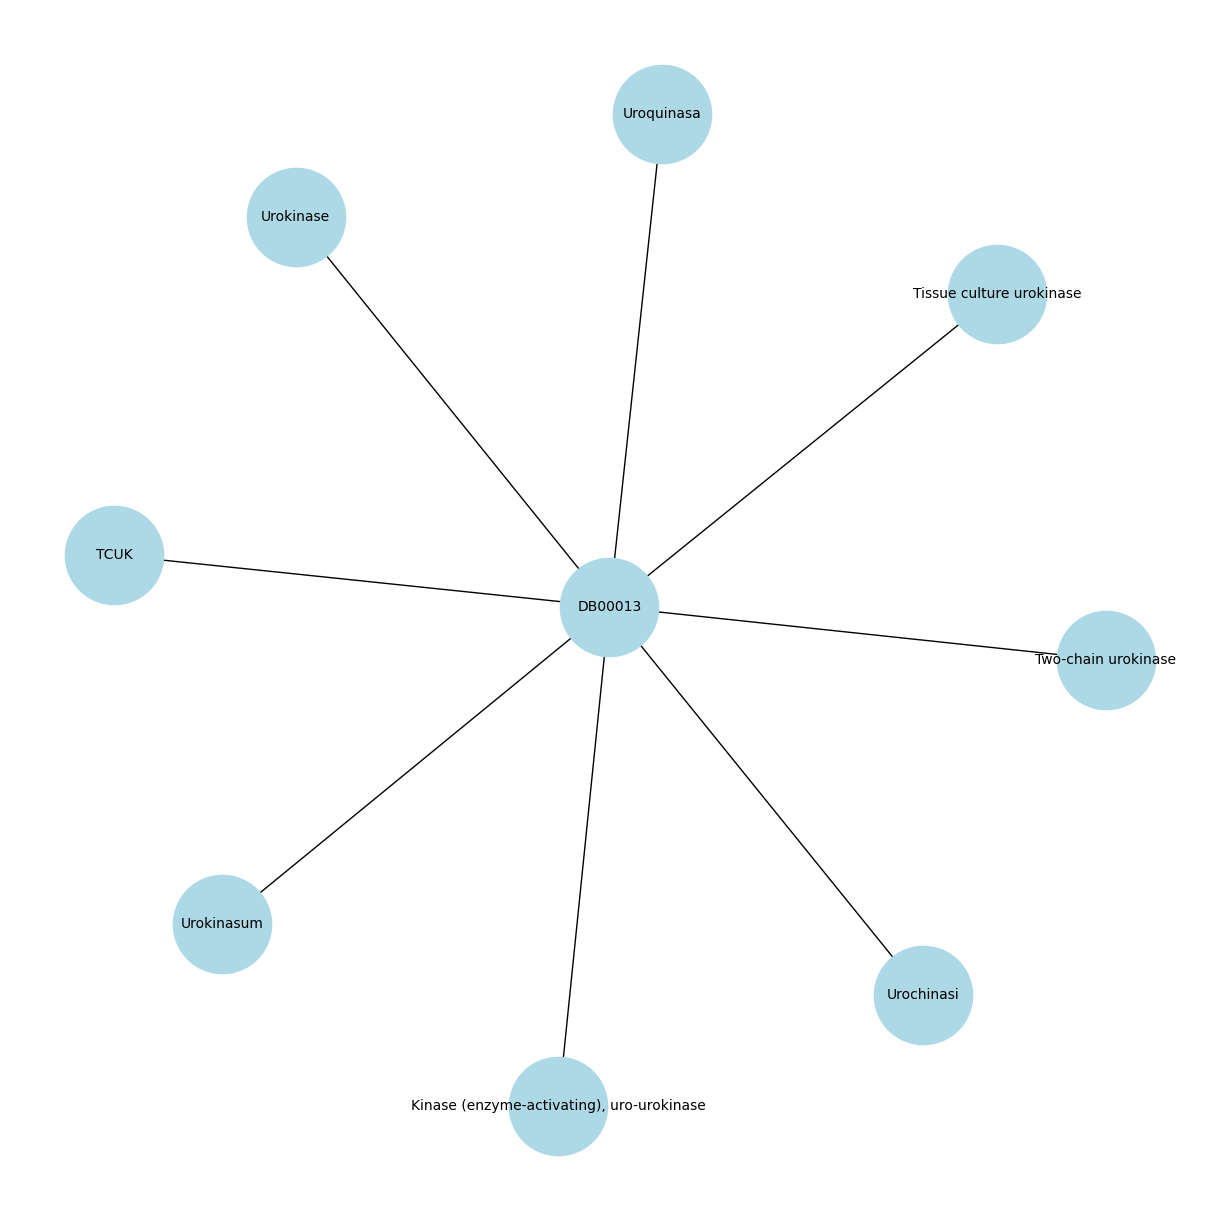

In [33]:
# returns DataFrame containing synonyms data for all drugs
def create_synonyms_dataframe(data):
    synonyms = []
    for drug in data.find('drugbank').find_all('drug', recursive=False):
        drug_id = drug.find('drugbank-id', {'primary': 'true'}, recursive=False).text
        drug_synonyms = [synonym.text for synonym in drug.find('synonyms', recursive=False).find_all('synonym', recursive=False)]

        synonyms.append({
            'DrugBank ID': drug_id,
            'Synonyms': drug_synonyms
        })
    return pd.DataFrame(synonyms)

synonyms_df = create_synonyms_dataframe(data)


import networkx as nx
import matplotlib.pyplot as plt

def create_synonyms_graph(synonyms_df, drug_id):
    G = nx.Graph()
    synonyms = synonyms_df.loc[synonyms_df['DrugBank ID'] == drug_id, 'Synonyms'].values[0]
    for synonym in synonyms:
        G.add_edge(drug_id, synonym)

    plt.figure(figsize=(12, 12))

    nx.draw(G, with_labels=True, font_size=10, node_size=5000, node_color='lightblue', font_color='black')
    plt.show()

create_synonyms_graph(synonyms_df, 'DB00013')

## Zadanie 3
Utworzyć ramkę danych o produktach farmaceutycznych zawierających dany lek
(substancję leczniczą). Ramka powinna zawierać informacje o ID leku, nazwie produktu,
producencie, kod w narodowym rejestrze USA (ang. *National Drug Code*), postać w jakiej
produkt występuje, sposób aplikacji, informacje o dawce, kraju i agencji rejestrującej
produkt

In [36]:
def create_pharmaceuticals_dataframe(data):
    pharmaceuticals = []
    for drug in data.find('drugbank').find_all('drug', recursive=False):
        drug_id = drug.find('drugbank-id', {'primary': 'true'}, recursive=False).text
        drug_products = drug.find('products', recursive=False)
        if drug_products:
            for product in drug_products.find_all('product', recursive=False):
                product_name = product.find('name', recursive=False).text
                product_manufacturer = product.find('labeller', recursive=False).text
                product_ndc = product.find('ndc-product-code', recursive=False).text
                product_form = product.find('dosage-form', recursive=False).text
                product_route = product.find('route', recursive=False).text
                product_dose = product.find('strength', recursive=False).text
                product_country = product.find('country', recursive=False).text
                product_regulatory_authority = product.find('source', recursive=False).text

                pharmaceuticals.append({
                    'DrugBank ID': drug_id,
                    'Product Name': product_name,
                    'Manufacturer': product_manufacturer,
                    'NDC': product_ndc,
                    'Form': product_form,
                    'Route': product_route,
                    'Dose': product_dose,
                    'Country': product_country,
                    'Regulatory Authority': product_regulatory_authority
                })

    return pd.DataFrame(pharmaceuticals)

pharmaceuticals_df = create_pharmaceuticals_dataframe(data)

## Zadanie 4
Utworzyć ramkę danych zawierającą informacje o wszystkich szlakach (sygnałowych,
metabolicznych) z jakimi jakikolwiek lek wchodzi w interakcje. Podać całkowitą liczbę tych
szlaków

## Zadanie 5
Dla każdego szlaku sygnałowego/metabolicznego w bazie danych podać leki, które
wchodzą z nim w interakcje. Wyniki należy przedstawić w postaci ramki danych jak i w
opracowanej przez siebie formie graficznej. Przykładem takiej grafiki może być graf
dwudzielny, gdzie dwa rodzaje wierzchołków to szlaki sygnałowe i leki, a poszczególne
krawędzie reprezentują interakcję danego leku z danym szlakiem sygnałowym. Należy
zadbać o czytelność i atrakcyjność prezentacji graficznej

## Zadanie 6
Dla każdego leku w bazie danych podać liczbę szlaków, z którymi dany lek wchodzi w
interakcje. Przedstawić wyniki w postaci histogramu z odpowiednio opisanymi osiami.

## Zadanie 7
Utworzyć ramkę danych zawierającą informacje o białkach, z którymi poszczególne leki
wchodzą w interakcje. Białka te to tzw. targety. Ramka danych powinna zawierać
przynajmniej DrugBank ID targetu, informację o zewnętrznej bazie danych (ang. *source*,
np. Swiss-Prot), identyfikator w zewnętrznej bazie danych, nazwę polipeptydu, nazwę genu
kodującego polipeptyd, identyfikator genu GenAtlas ID, numer chromosomu, umiejscowienie
w komórce.

## Zadanie 8
Utworzyć wykres kołowy prezentujący procentowe występowanie targetów w różnych
częściach komórki.

## Zadanie 9
Utworzyć ramkę danych, pokazującą ile leków zostało zatwierdzonych, wycofanych, ile
jest w fazie eksperymentalnej (ang. *experimental* lub *investigational*) i dopuszczonych w
leczeniu zwierząt. Przedstawić te dane na wykresie kołowym. Podać liczbę zatwierdzonych
leków, które nie zostały wycofane.

## Zadanie 10
Utworzyć ramkę danych opisującą w jaki sposób dany lek wchodzi w interakcje ze
swoimi targetami

## Zadanie 11
Opracować według własnego pomysłu graficzną prezentację zawierającą informacje o
konkretnym genie lub genach, substancjach leczniczych, które z tym genem/genami
wchodzą w interakcje, oraz produktach farmaceutycznych, które zawierają daną substancję
leczniczą. Wybór dotyczący tego, czy prezentacja graficzna jest realizowana dla
konkretnego genu, czy wszystkich genów jednocześnie pozostawiamy Państwa decyzji.
Przy dokonywaniu wyboru należy kierować się czytelnością i atrakcyjnością prezentacji
graficznej

## Zadanie 12
Zaproponować własną analizę i prezentację danych dotyczących leków. Można w tym
celu pozyskiwać dodatkowe informacje z innych biomedycznych i bioinformatycznych baz
danych dostępnych online. Należy jednak upewnić się, czy dana baza danych pozwala na
zautomatyzowane pobieranie danych przez program. Na przykład baza danych GeneCards
wprost tego zabrania, co zostało na czerwono podkreślone na tej stronie. Przykładowe bazy
danych to: UniProt (https://www.uniprot.org/), Small Molecule Pathway Database
(https://smpdb.ca/), The Human Protein Atlas (https://www.proteinatlas.org/)

## Zadanie 13
Stworzyć symulator, który generuje testową bazę 20000 leków. Wartości generowanych
19900 leków w kolumnie “DrugBank Id” powinny mieć kolejne numery, a w pozostałych
kolumnach wartości wylosowane spośród wartości istniejących 100 leków. Zapisz wyniki w
pliku drugbank_partial_and_generated.xml. Przeprowadź analizę według punktów 1-12
testowej bazy

## Zadanie 14
Przygotować testy jednostkowe z pomocą biblioteki pytest.

## Zadanie 15
Zrealizować punkt 6 tak, aby możliwe było wysłanie id leku na Twój serwer, który zwróci
wynik w odpowiedzi (skorzystaj z fastapi i uvicorn; wystarczy zademonstrowanie przesłania
danych metodą POST, przez Execute w dokumentacji)